<h1>Projeto de Identificação de Imagens</h1><br>

In [2]:
import os
import random
import tarfile
import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image, ImageOps
from skimage import exposure
from skimage.util import montage
from scipy.ndimage import convolve, median_filter
from tqdm import tqdm

We start the project making sure that the database is usable by transforming every single image that we have in a smaller version.

In [4]:
# root directories
root_dir = 'images_png'
output_dir = 'image_database'
metadata_file = os.path.join(output_dir, 'metadata.txt')

with open(metadata_file, 'w') as meta:
    meta.write("")

# resize images
for subdir in os.listdir(root_dir):
    subdir_path = os.path.join(root_dir, subdir)
    if os.path.isdir(subdir_path):
        # create a new subdir for every subdir found in the root_dir
        output_subdir = os.path.join(output_dir, subdir)
        os.makedirs(output_subdir, exist_ok=True)

        # for every image, create a new line in class in metadata
        with open(metadata_file, 'a') as meta:
            meta.write(f"Class {subdir}:\n")

        for filename in os.listdir(subdir_path):
            if filename.lower().endswith('.png'):
                img = Image.open(os.path.join(subdir_path, filename))
                img_resized = img.resize((600, 600))
                output_path = os.path.join(output_subdir, filename)
                img_resized.save(output_path, 'PNG')
                print(f"Redimensionada: {filename} -> {output_path}")

                # write in the metadata file the last resized image
                with open(metadata_file, 'a') as meta:
                    meta.write(f"{filename}\n")

        with open(metadata_file, 'a') as meta:
            meta.write("\n")

print("Done!\nNew database created.")

Redimensionada: 0-01-V1-B.png -> image_database\0\0-01-V1-B.png
Redimensionada: 0-01-V1-W.png -> image_database\0\0-01-V1-W.png
Redimensionada: 0-01-V2-B.png -> image_database\0\0-01-V2-B.png
Redimensionada: 0-01-V2-W.png -> image_database\0\0-01-V2-W.png
Redimensionada: 0-02-V1-B.png -> image_database\0\0-02-V1-B.png
Redimensionada: 0-02-V1-W.png -> image_database\0\0-02-V1-W.png
Redimensionada: 0-02-V2-B.png -> image_database\0\0-02-V2-B.png
Redimensionada: 0-02-V2-W.png -> image_database\0\0-02-V2-W.png
Redimensionada: 0-03-V1-B.png -> image_database\0\0-03-V1-B.png
Redimensionada: 0-03-V1-W.png -> image_database\0\0-03-V1-W.png
Redimensionada: 0-03-V2-B.png -> image_database\0\0-03-V2-B.png
Redimensionada: 0-03-V2-W.png -> image_database\0\0-03-V2-W.png
Redimensionada: 0-04-V1-B.png -> image_database\0\0-04-V1-B.png
Redimensionada: 0-04-V1-W.png -> image_database\0\0-04-V1-W.png
Redimensionada: 0-04-V2-B.png -> image_database\0\0-04-V2-B.png
Redimensionada: 0-04-V2-W.png -> image_d

We choose randomly an image to show to the user to verify the resizing output.

Image '3\3-02-V2-W.png' size: (600, 600)


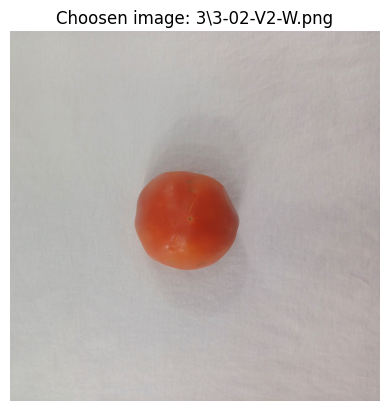

In [5]:
# list all possible image paths
all_images = []
for subdir in os.listdir(output_dir):
    subdir_path = os.path.join(output_dir, subdir)
    if os.path.isdir(subdir_path):
        for filename in os.listdir(subdir_path):
            all_images.append(os.path.join(subdir, filename))

if all_images:
    random_image_path = random.choice(all_images)
    img = Image.open(os.path.join(output_dir, random_image_path))
    
    # show image size
    print(f"Image '{random_image_path}' size: {img.size}")
    # show random image
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Choosen image: {random_image_path}")
    plt.show()
else:
    print("No image found on the dataset!")

<h2>Dataset Augmentation</h2>
Every single augmentation function works randomly to have better results.

In [ ]:
# From here on we are considering the "root dir" as the database
root_dir = 'image_database'
augmented_dir = 'augmented_dataset'
os.makedirs(augmented_dir, exist_ok=True)

def random_flip(img):
    if random.choice([True, False]):
        # Horizontal flip
        return ImageOps.mirror(img)
    else:
        # Vertical flip
        return ImageOps.flip(img)

def random_rotation(img):
    angle = random.randint(30, 60)
    rotated_img = img.rotate(angle, expand=True)
    
    # Apply a random flip to add rotation to the image
    # this ensures that flipped/mirror images and rotated images are never the same
    if random.choice([True, False]):
        rotated_img = ImageOps.mirror(rotated_img)
    if random.choice([True, False]):
        rotated_img = ImageOps.flip(rotated_img)
    
    return rotated_img

def random_noise(img):
    # Apply random noise to the image
    np_img = np.array(img)
    noise = np.random.normal(0, 25, np_img.shape).astype(np.int16)
    noisy_img = np.clip(np_img + noise, 0, 255).astype(np.uint8)
    return Image.fromarray(noisy_img)

def random_crop(img):
    width, height = img.size
    # Defines that the zoom cant extend half the original size
    max_crop = min(width, height) // 2
    crop_size = width - random.randint(10, max_crop)
    
    left = (width - crop_size) // 2
    top = (height - crop_size) // 2
    right = left + crop_size
    bottom = top + crop_size

    cropped_img = img.crop((left, top, right, bottom))
    return cropped_img.resize((width, height), Image.Resampling.LANCZOS)

def _log(image):
    image = np.array(image)
    image_normalized = image / 255.0
    # Apply log(1 + x)
    image_log = np.log(1 + image_normalized)
    # Return the image values between [0, 255]
    return Image.fromarray((image_log * 255).astype(np.uint8))

def _exp(image):
    image = np.array(image)
    image_normalized = image / 255.0
    # exp(x) - 1
    image_exp = np.exp(image_normalized) - 1
    # Limits in [0, 1]
    image_exp = np.clip(image_exp, 0, 1)
    # Return the image values between [0, 255]
    return Image.fromarray((image_exp * 255).astype(np.uint8))

def _avg_filter(image):
    image = np.array(image)
    # Defines a simple 3x3 mask
    kernel = np.ones((3, 3)) / 9
    # Apply convolve
    if len(image.shape) == 3:
        filtered_image = np.stack([convolve(image[..., i], kernel) for i in range(3)], axis=-1).astype(np.uint8)
    else:
        filtered_image  = convolve(image, kernel).astype(np.uint8)
    return Image.fromarray(filtered_image)

With the augmentation functions defined, we run for every single image in the dataset.

In [ ]:
metadata_file = os.path.join(augmented_dir, 'metadata.txt')
is_a_test = False

for subdir in os.listdir(root_dir):
    subdir_path = os.path.join(root_dir, subdir)
    if os.path.isdir(subdir_path):
        output_subdir = os.path.join(augmented_dir, subdir)
        os.makedirs(output_subdir, exist_ok=True)

        with open(metadata_file, 'a') as meta:
            meta.write(f"Class {subdir}:\n")

        for filename in os.listdir(subdir_path):
            if filename.lower().endswith('.png'):
                img = Image.open(os.path.join(subdir_path, filename))

                # Save the original image
                img.save(os.path.join(output_subdir, f"{filename}_original.png"))
                with open(metadata_file, 'a') as meta:
                    meta.write(f"{filename}\n")

                if is_a_test:
                    # Call the augmentation functions and save the results
                    random_flip(img).save(os.path.join(output_subdir, f"{filename}_flip.png"))
                    random_rotation(img).save(os.path.join(output_subdir, f"{filename}_rot.png"))
                    random_noise(img).save(os.path.join(output_subdir, f"{filename}_noise.png"))
                    random_crop(img).save(os.path.join(output_subdir, f"{filename}_crop.png"))

                else:
                    # Call the specified augmentation functions
                    _log(img).save(os.path.join(output_subdir, f"{filename}_log.png"))
                    _exp(img).save(os.path.join(output_subdir, f"{filename}_exp.png"))
                    _avg_filter(img).save(os.path.join(output_subdir, f"{filename}_avg.png"))

                print(f"Augmented: {filename} -> {output_subdir}")
                
        with open(metadata_file, 'a') as meta:
            meta.write("\n")

print("Done!\nData augmented!")

Augmented: 0-01-V1-B.png -> augmented_dataset\0
Augmented: 0-01-V1-W.png -> augmented_dataset\0
Augmented: 0-01-V2-B.png -> augmented_dataset\0
Augmented: 0-01-V2-W.png -> augmented_dataset\0
Augmented: 0-02-V1-B.png -> augmented_dataset\0
Augmented: 0-02-V1-W.png -> augmented_dataset\0
Augmented: 0-02-V2-B.png -> augmented_dataset\0
Augmented: 0-02-V2-W.png -> augmented_dataset\0
Augmented: 0-03-V1-B.png -> augmented_dataset\0
Augmented: 0-03-V1-W.png -> augmented_dataset\0
Augmented: 0-03-V2-B.png -> augmented_dataset\0
Augmented: 0-03-V2-W.png -> augmented_dataset\0
Augmented: 0-04-V1-B.png -> augmented_dataset\0
Augmented: 0-04-V1-W.png -> augmented_dataset\0
Augmented: 0-04-V2-B.png -> augmented_dataset\0
Augmented: 0-04-V2-W.png -> augmented_dataset\0
Augmented: 0-05-V1-B.png -> augmented_dataset\0
Augmented: 0-05-V1-W.png -> augmented_dataset\0
Augmented: 0-05-V2-B.png -> augmented_dataset\0
Augmented: 1-01-V1-B.png -> augmented_dataset\1
Augmented: 1-01-V1-W.png -> augmented_da

Now, as asked in the project instructions, we are going to compact all images to create the dataset.

In [64]:
tar_filename = 'augmented_dataset.tar.gz'

with tarfile.open(tar_filename, 'w:gz') as tar:
    tar.add(output_dir, arcname=os.path.basename(output_dir))

print(f"Done: {tar_filename}.")

Done: augmented_dataset.tar.gz.


Below we have a code to view the images by class.

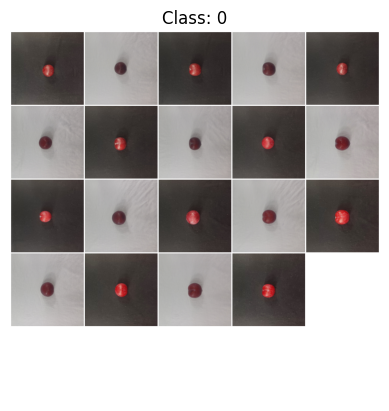

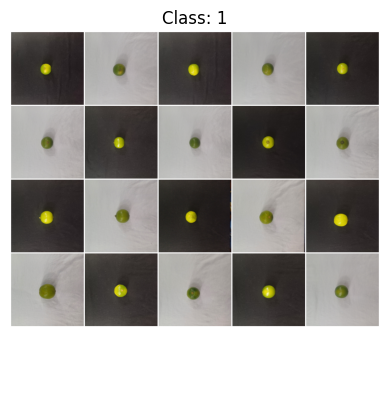

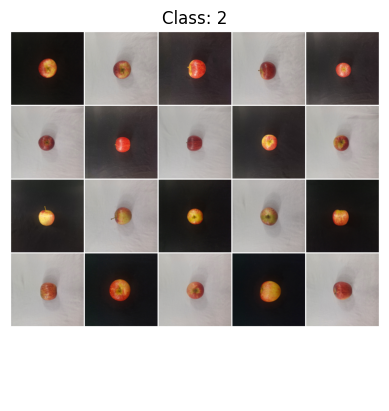

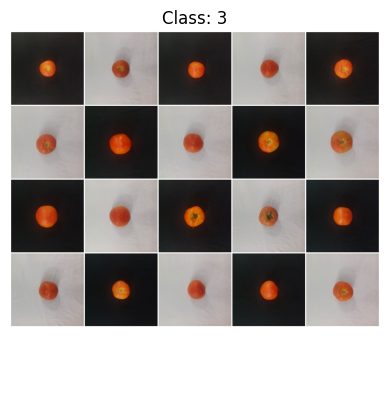

In [65]:
def load_images_for_class(class_dir, max_images=20):
    images = []
    for filename in os.listdir(class_dir):
        if filename.lower().endswith('original.png'):
            img = Image.open(os.path.join(class_dir, filename)).convert('RGB')
            img = img.resize((128, 128))
            images.append(np.array(img))
            if len(images) >= max_images:
                break
    return np.array(images)

def show_montage(images, title):
    # We had problems using montage as it needs a 4D vector to work with colored images
    if images.ndim == 3:
        images = images[..., np.newaxis]
    if images.ndim == 4:
        # Using channel_axis=-1 we ensure that the dimensions are in the expected way for montage()
        m = montage(images, grid_shape=(5, 5), padding_width=2, fill=(255, 255, 255), channel_axis=-1)
        plt.imshow(m)
        plt.title(title)
        plt.axis('off')
        plt.show()
    else:
        print("Images are not in 4D.\nExiting")

# Show a montage for every single class using the original images
for class_name in os.listdir(augmented_dir):
    class_path = os.path.join(augmented_dir, class_name)
    if os.path.isdir(class_path):
        images = load_images_for_class(class_path)
        if len(images) > 0:
            show_montage(images, f"Class: {class_name}")

<h1>Dataset Normalization</h1>
Here we do some operations to create a normalized dataset.<br>
We start with basic functions for Class Prototype and Histograms.

In [66]:
def normalize_images(directory):
    images = []
    for filename in os.listdir(directory):
        img_path = os.path.join(directory, filename)
        img = Image.open(img_path).convert('RGB')
        img = img.resize((600, 600))  # Redimensiona para o tamanho alvo
        img = np.array(img) / 255.0  # Normaliza a imagem para o intervalo [0, 1]
        images.append(img)
    return np.array(images)

def calculate_class_prototype(images):
    return np.mean(images, axis=0)

def calculate_histogram(image):
    return np.histogram(image.flatten(), bins=256, range=(0, 1))[0]

def calculate_average_histogram(images):
    histograms = np.array([calculate_histogram(img) for img in images])
    return np.mean(histograms, axis=0)

def calculate_histogram_variance(images):
    histograms = np.array([calculate_histogram(img) for img in images])
    return np.var(histograms, axis=0)

With the normalization functions made, we just call every single one for every class we have.


Class: 0

Class: 1

Class: 2

Class: 3


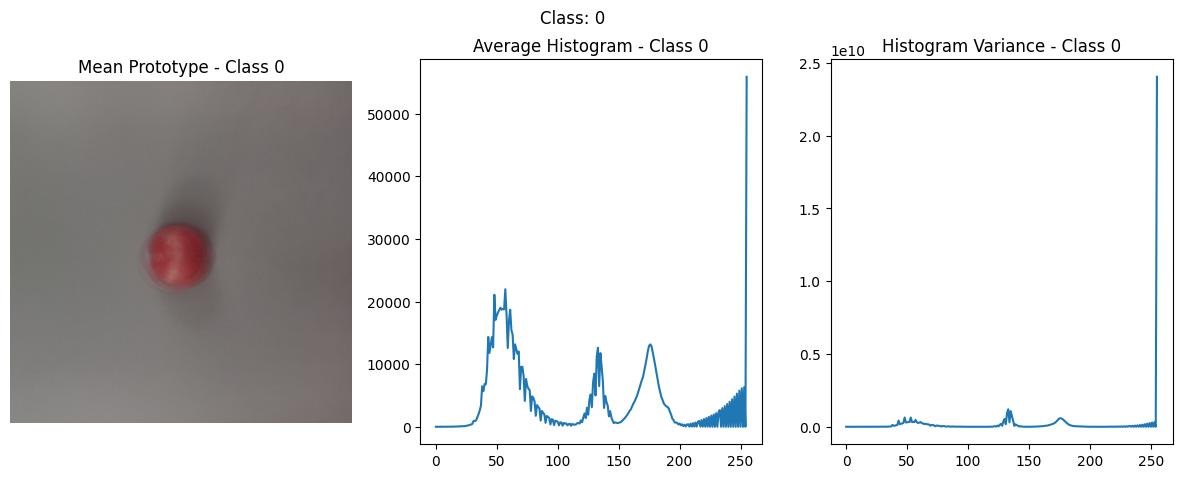

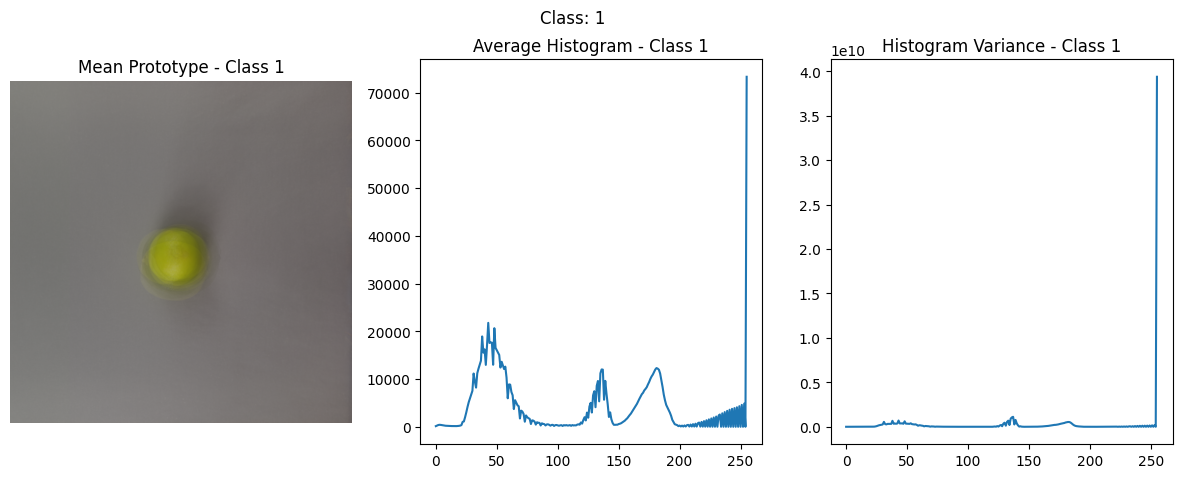

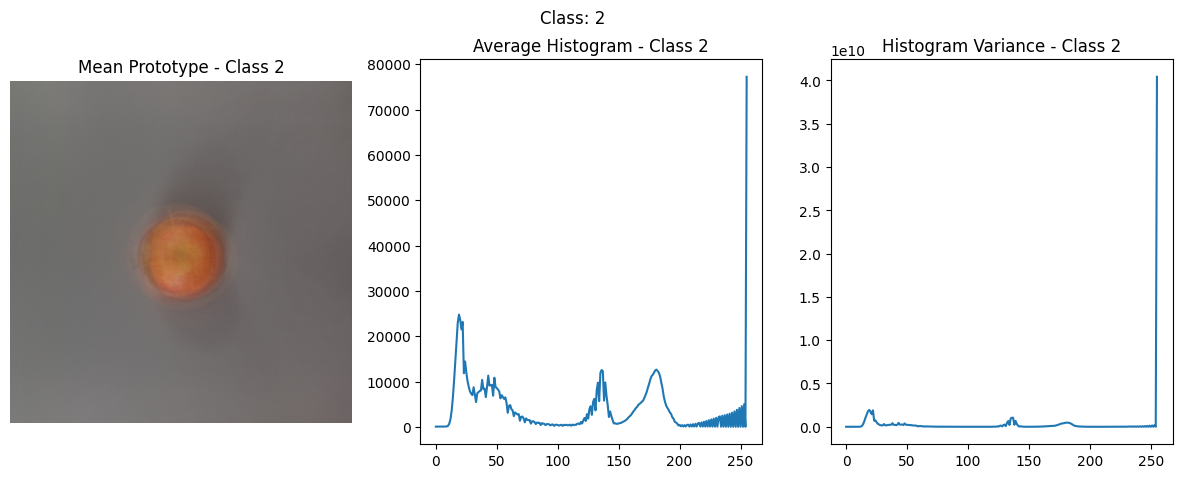

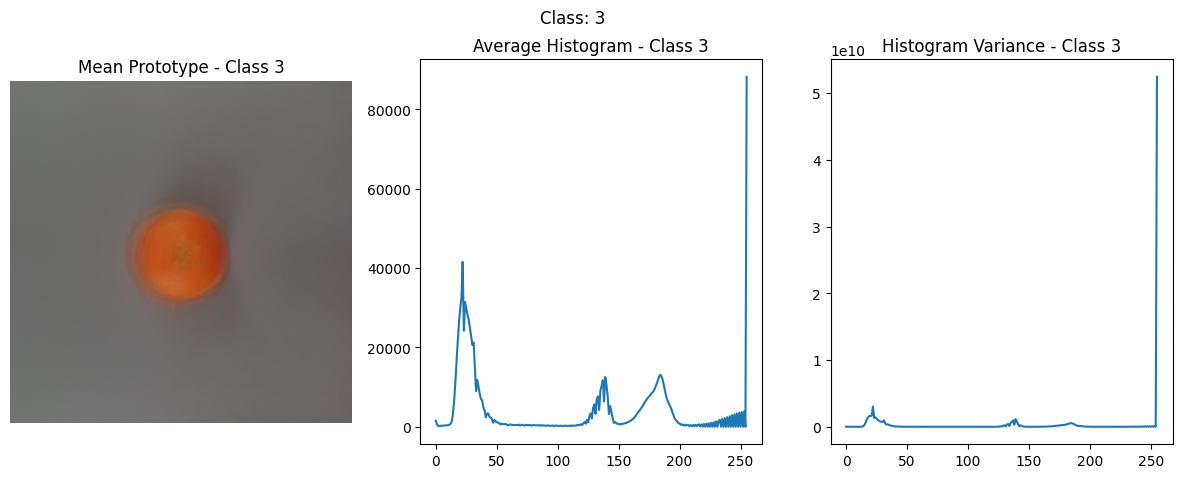

In [67]:
class_names = os.listdir(augmented_dir)
images = []
for class_name in class_names:
    class_path = os.path.join(augmented_dir, class_name)
    if os.path.isdir(class_path):
        print(f"\nClass: {class_name}")

        images = normalize_images(class_path)
        
        # Create a subplot to show every image together
        fig, axes = plt.subplots(1, 3, figsize=(15,5))
        ax = axes.ravel()
        fig.suptitle(f"Class: {class_name}")

        class_prototype = calculate_class_prototype(images)
        ax[0].imshow(class_prototype)
        ax[0].set_title(f"Mean Prototype - Class {class_name}")
        ax[0].axis('off')
        
        avg_histogram = calculate_average_histogram(images)
        ax[1].plot(avg_histogram)
        ax[1].set_title(f"Average Histogram - Class {class_name}")

        hist_variance = calculate_histogram_variance(images)
        ax[2].plot(hist_variance)
        ax[2].set_title(f"Histogram Variance - Class {class_name}")

<h1>Segmentation</h1>
Here we separate the main interest object from its background.<br>
We have done some of this segmentation manually, as asked in the instructions, but for some we used an algorithm.<br>
For the algorithm, we are implementing Otsu Thresholding, as the database is composed of images with a good difference between the object of interest and the background.

In [68]:
def otsu_threshold(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    _, binary_mask = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Otsu outputs an inverted ground truth for images with black backgrounds
    # Here we invert then using a bitwise NOT
    if 'B' in os.path.basename(image_path):
        binary_mask = cv2.bitwise_not(binary_mask) 

    return binary_mask

def check_white_pixels(binary_mask, threshold_ratio=0.25):
    white_pixels = cv2.countNonZero(binary_mask)
    total_pixels = binary_mask.size
    white_ratio = white_pixels / total_pixels
    return white_ratio > threshold_ratio

For this, we run to at least 20% of every class, something that can be changed by the 'percentage' variable.<br>
We also run this randomly, without ever duplicating an image.

In [ ]:
ground_truth_dir = "ground_truth"
percentage = 0.5 # THIS IS FOR TESTS PURPOSES, CHANGE IT (It seems that the higher the percentage, the better the classificator)
max_attempts = 5
check_segmented_image = False

os.makedirs(ground_truth_dir, exist_ok=True)

for class_name in os.listdir(augmented_dir):
    class_path = os.path.join(augmented_dir, class_name)
    output_class_path = os.path.join(ground_truth_dir, class_name)
    
    if os.path.isdir(class_path):
        os.makedirs(output_class_path, exist_ok=True)
        image_files = [f for f in os.listdir(class_path) if f.endswith(('.png')) and not f.endswith(('noise.png'))]
        
        sample_size = max(1, int(len(image_files) * percentage))
        selected_images = random.sample(image_files, sample_size)
        
        for image_name in selected_images:
            image_path = os.path.join(class_path, image_name)
            segmented_image = otsu_threshold(image_path)
            attempts = 0

            if check_segmented_image:
                while check_white_pixels(segmented_image, threshold_ratio=0.1) and attempts < max_attempts:
                    print(f"Excess of white pixels in {image_name}. Replacing with another image...")
                    selected_images.remove(image_name)

                    # if theres no images left, don't select a new one
                    if len(selected_images) == 0:
                        selected_images = random.sample(image_files, sample_size)

                    image_name = random.choice(selected_images)  
                    print(f"Replaced with {image_name}")
                    image_path = os.path.join(class_path, image_name)
                    segmented_image = otsu_threshold(image_path)
                    attempts += 1
                
                if check_white_pixels(segmented_image, threshold_ratio=0.1):
                    print(f"Failed to get a good ground truth for {image_name} after {max_attempts} attempts.")
                    continue
            
            save_path = os.path.join(output_class_path, f"{os.path.splitext(image_name)[0]}_gt.png")
            cv2.imwrite(save_path, segmented_image)

print("Done!\nGround Truth created.")

Done!
Ground Truth created.


For some of the images, we can see good results using Otsu Thresholding, but if the image has noise, we have a problem.<br>
For this, we will use mathematical morphology techniques so that we can fix these errors, such as opening and closing, and also use the opencv lib to try to delete small pixels and create a circle maks around the object of interest.

In [ ]:
for class_name in os.listdir(ground_truth_dir):
    class_path = os.path.join(ground_truth_dir, class_name)
    if not os.path.isdir(class_path):
        continue
    
    for filename in os.listdir(class_path):
        img_path = os.path.join(class_path, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        
        img_filtered = median_filter(img, size=3)
        
        # Remove small objects with the cv2.connectedComponentsWithStats function
        num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(img_filtered, connectivity=8)
        min_area = 50  # This value is manually adjusted
        img_cleaned = np.zeros_like(img_filtered)

        # This should ignore the background
        for i in range(1, num_labels):
            if stats[i, cv2.CC_STAT_AREA] >= min_area:
                img_cleaned[labels == i] = 255

        # Apply mathematical morphology using opencv
        kernel = np.ones((2, 2), np.uint8)
        img_morph = cv2.morphologyEx(img_cleaned, cv2.MORPH_CLOSE, kernel)
        img_morph = cv2.morphologyEx(img_morph, cv2.MORPH_OPEN, kernel)

        # As we now that the main object is in the center, we create a mask using np.zeros
        # to delete extra pixels outside the center
        h, w = img_morph.shape
        mask = np.zeros((h, w), dtype=np.uint8)
        center_x, center_y = w // 2, h // 2
        radius = min(h, w) // 4  # Define the radius based on the center
        cv2.circle(mask, (center_x, center_y), radius, 255, thickness=-1)

        # Apply mask
        img_morph = cv2.bitwise_and(img_morph, mask)
        
        refined_path = os.path.join(class_path, f"{filename}")
        Image.fromarray(img_morph).save(refined_path)

print("Images refined.")

Images refined.


Now with the Ground Truth created, we can work generating the bounding boxes for them.

In [120]:
bounding_boxes_dir = "bounding_boxes"
os.makedirs(bounding_boxes_dir, exist_ok=True)

for class_name in os.listdir(ground_truth_dir):
    class_path = os.path.join(ground_truth_dir, class_name)
    output_class_path = os.path.join(bounding_boxes_dir, class_name)
    os.makedirs(output_class_path, exist_ok=True)
    
    if not os.path.isdir(class_path):
        continue
    
    for filename in tqdm(os.listdir(class_path), desc=f"Processing {class_name}"):
        img_path = os.path.join(class_path, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        
        if img is None:
            continue

        contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        if len(contours) > 0:
            # Find the largest contour
            largest_contour = max(contours, key=cv2.contourArea)
            x, y, w, h = cv2.boundingRect(largest_contour)
            
            img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
            cv2.rectangle(img_rgb, (x, y), (x + w, y + h), (0, 255, 0), 2)
            
            output_path = os.path.join(output_class_path, filename)
            Image.fromarray(img_rgb).save(output_path)

print("Bounding boxes generated successfully.")

Processing 3: 100%|██████████| 40/40 [00:00<00:00, 132.05it/s]

Bounding boxes generated successfully.


<h1>Classification</h1>
Now that we worked with our dataset to create all the information needed for each class, we can start the classification process<br>

In [110]:
import pandas as pd
from skimage.measure import regionprops, label
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import seaborn as sns


For this, we build a feature vector for every class.

In [121]:
def extract_features(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    labeled_img = label(img > 0)
    props = regionprops(labeled_img)
    
    if not props:
        return None
    
    # Takes the biggest region found
    region = props[0]
    bbox_area = region.area
    aspect_ratio = region.bbox[3] / max(region.bbox[2], 1)  # width / height
    perimeter = region.perimeter
    eccentricity = region.eccentricity
    mean_intensity = np.mean(img[img > 0])
    variance_intensity = np.var(img[img > 0])
    
    return [bbox_area, aspect_ratio, perimeter, eccentricity, mean_intensity, variance_intensity]

And we rund the code for every single class (in subdirectiories), creating a .csv of information.

In [122]:
output_csv = "bounding_box_features.csv"
data = []

for class_name in os.listdir(bounding_boxes_dir):
    class_path = os.path.join(bounding_boxes_dir, class_name)
    if not os.path.isdir(class_path):
        continue
    
    for filename in os.listdir(class_path):
        img_path = os.path.join(class_path, filename)
        features = extract_features(img_path)
        if features:
            data.append([class_name, filename] + features)

columns = ["Class", "Filename", "BBox_Area", "Aspect_Ratio", "Perimeter", "Eccentricity", "Mean_Intensity", "Variance_Intensity"]
df = pd.DataFrame(data, columns=columns)
df.to_csv(output_csv, index=False)
print(f"Feature extraction completed. Saved to {output_csv}")

Feature extraction completed. Saved to bounding_box_features.csv


Now we can train a classificator for the data created. We are going to use the Decision Tree model available in the sklearn lib.<br>
As asked, we are going to use 80% of the data to train, 10% to validation and 10% to tests

In [123]:
# Load the .csv
data = pd.read_csv("bounding_box_features.csv")

# separate the label collumn from the data
X = data.drop(columns=["Class"])
X = X.select_dtypes(include=[np.number]) # remove non-numeric columns (the classifier cant work with string) 
y = data["Class"]

# Split the data to train, tests and validation
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Create and train the classified
classifier = DecisionTreeClassifier(random_state=42)
classifier.fit(X_train, y_train)

# Evaluate the classifier results with accuracy tests
y_val_pred = classifier.predict(X_val)
val_acc = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {val_acc:.4f}")

# Now tests the classifier with the same tests
y_test_pred = classifier.predict(X_test)
test_acc = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_acc:.4f}")

Validation Accuracy: 0.8750
Test Accuracy: 0.6875


Now we can work with the accuracy metrics and generate a confusion matrix and F1-score.

Accuracy: 0.6875
F1-score: 0.6845

Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.50      0.57         4
           1       0.60      0.75      0.67         4
           2       0.75      0.75      0.75         4
           3       0.75      0.75      0.75         4

    accuracy                           0.69        16
   macro avg       0.69      0.69      0.68        16
weighted avg       0.69      0.69      0.68        16



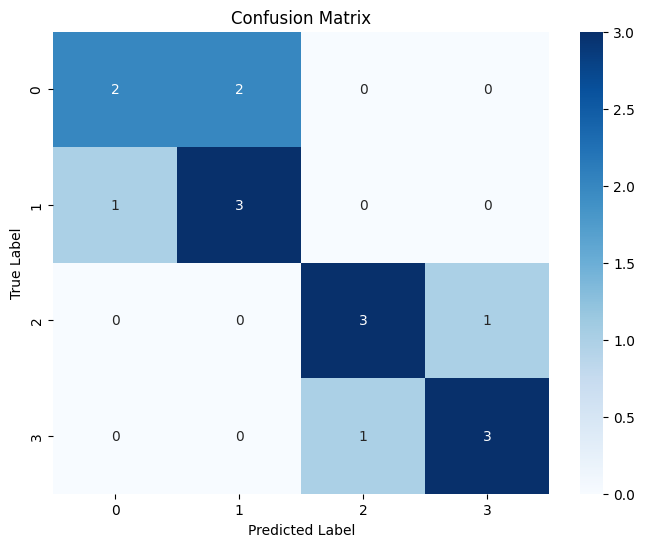

In [124]:
# Make predictions with the tests
y_test_pred = classifier.predict(X_test)

# Calculate metrics
accuracy = accuracy_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"F1-score: {f1:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_test_pred))

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=set(y_test), yticklabels=set(y_test))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()